In [ ]:
import pandas as pd
import wandb
from tqdm import tqdm

api = wandb.Api()
entity, project = "st7ma784", "Bertscore"
runs = api.runs(entity + "/" + project)
metric_to_Grab=["F1"]
Group_by=[#"modelname",
"modelname",
"LSAVersion",
#"perfect_match",
#"padding_length"
]
ignore_values=["albert-base-v2","roberta-base"]
data={}
options={k:set() for k in Group_by}
print("Grabbing data:")
run_configs=set()
for run in tqdm(runs):
       
    if run.state == "finished" or run.summary.get("e_F1",-1)>0: #other check for all logging complete 
        hist=run.history()
        # print(hist)
        config=run.config
        #print(config)        
        sortedkeys=list([str(i) for i in config.keys()])
        sortedkeys.sort()
        items=list([str(config[i]) for i in sortedkeys])
        code="_".join(items)
        if not any([item in ignore_values for item in config.items()]) and config["batch_size"]==180 and code not in run_configs:
            run_configs.add(code)

            dictkeys=list(set(config.keys()).intersection(set(Group_by)))
            dictkeys.sort()
            for k in dictkeys:
                s=options[k]
                s.add(config.get(k,""))
                options[k]=s
            entry_name= "_".join([config.get(k,"") for k in dictkeys])
            #print(entry_name)

            dictkeys=set(hist.keys()).intersection(set(metric_to_Grab))
            for k in dictkeys:
                lis=data.get(entry_name,[])
                lis.extend(hist[k])
                data[entry_name]=lis
    
    
        # for k in dictkeys:
        #     summarydict[k].append(hist[k])



In [ ]:
options

In [ ]:
import seaborn as sns
# %matplotlib_inline
import matplotlib.pyplot as plt

figure=plt.figure()
i=0
for key in options:
    for entry in options[key]:
        #filter data by data.key() includes entry
        newdict={k:v for k,v in data.items() if entry in k.split("_")}
        figure=plt.figure(i)
        i+=1
        plot=sns.histplot(data=newdict, kde = True,)
        

In [ ]:
#proof of concept. 

#We're going to take all runs, and then do a set of configs,

#During creation of the set, if there is the same config with 384 and 128 for padding length, we're going to plot a histogram of each set of results. 
import pandas as pd
import wandb
from tqdm import tqdm
from itertools import chain

api = wandb.Api()
entity, project = "st7ma784", "Bertscore"
runs = api.runs(entity + "/" + project)
metric_to_Grab=["F1"]
ignore_values=["albert-base-v2","roberta-base"]
data={}
print("Grabbing data:")
codepairs=[]
run_configs=set()
for run in tqdm(runs):
    if run.state == "finished" or run.summary.get("e_F1",-1)>0: #other check for all logging complete 
        config=run.config
        sortedkeys=list([str(i) for i in config.keys()])
        sortedkeys.sort()
        values=list([str(config[i]) for i in sortedkeys])
        code="_".join(values)
        if not any([item in ignore_values for item in config.values()]) and config["batch_size"]==180:
            run_configs.add(code)
for code in run_configs:
    othercode=code
    if "128" in code:
        othercode=code.replace("128","384")
    elif "384" in code:
        othercode=code.replace("384","128")
    if othercode in run_configs:
        codepairs.append((code,othercode))

tests={}
print("saving runs where tests exist")
for run in tqdm(runs):
    if run.state == "finished" or run.summary.get("e_F1",-1)>0: #other check for all logging complete 
        config=run.config

        sortedkeys=list([str(i) for i in config.keys()])
        sortedkeys.sort()
        print(sortedkeys)
        values=list([str(config[i]) for i in sortedkeys])
        code="_".join(values)

        if code in chain.from_iterable(codepairs):
            newcode=code.replace("128","")
            newcode=newcode.replace("384","")
            hist=run.history()
            
            dictkeys=set(hist.keys()).intersection(set(metric_to_Grab))
            for k in dictkeys:
                lis=tests.get(newcode,{})
                code="Padding Length = {}".format(128 if "128" in code else 384)
                lis[code]=hist[k]
                tests[newcode]=lis


In [ ]:
import seaborn as sns
# %matplotlib_inline
import matplotlib.pyplot as plt
from tqdm import tqdm
figure=plt.figure()
i=0
for key in tqdm(tests):
    if key.startswith("none"):
        figure=plt.figure(i)
        i+=1
        plot=sns.histplot(data=tests[key], kde = True,)
        print(key)

We're going to generalise the above code block to allow us to generate graphs of any set of sweep that is comprehensive 

In [ ]:
tests={}
print("saving runs where tests exist")
for run in tqdm(runs):
    if run.state == "finished" or run.summary.get("e_F1",-1)>0: #other check for all logging complete 
        config=run.config

        sortedkeys=list([str(i) for i in config.keys()])
        sortedkeys.sort()
        # print(sortedkeys)
        values=list([str(config[i]) for i in sortedkeys])
        code="_".join(values)
        for group in codesets:
            if code in group[1]:
                key=group[0]
                args=code.split("_")
                argindex=sortedkeys.index(key)
                value=code.split("_")[argindex]
                first=args[:argindex] if argindex>0 else []
                last=args[argindex:] if argindex != len(args)-1 else []
                testname="_".join(first+last)

                hist=run.history()
            
                dictkeys=set(hist.keys()).intersection(set(metric_to_Grab))
                for k in dictkeys:
                    lis=tests.get(testname,{})
                    code="{} = {}".format(key,value)
                    lis[code]=hist[k]
                    tests[testname]=lis

In [13]:
#proof of concept. 

#We're going to take all runs, and then do a set of configs,

#During creation of the set, if there is the same config with 384 and 128 for padding length, we're going to plot a histogram of each set of results. 
import pandas as pd
import wandb
from tqdm import tqdm
from itertools import chain

api = wandb.Api()
entity, project = "st7ma784", "Bertscore"
runs = api.runs(entity + "/" + project)
metric_to_Grab=["F1"]
ignore_values=[]#"albert-base-v2","roberta-base"]
keys_of_interest=set(["LSAVersion","all_layers","modelname","padding_length","perfect_match"])
data={}
print("Grabbing data:")
codepairs=[]
run_configs=set()
keyvaluesets={}

'''Code to find all runs that have completed'''
for run in tqdm(runs):
    if run.state == "finished" or run.summary.get("e_F1",-1)>0: #other check for all logging complete 
        config=run.config

        sortedkeys=list([str(i) for i in config.keys() if i in keys_of_interest])
        sortedkeys.sort()
        values={i:config[i] for i in sortedkeys if i in keys_of_interest}
        values["perfect_match"]= not values["perfect_match"] # fix the error in code :-(
        values=list([str(values[i]) for i in sortedkeys])
        
        for k,v in zip(sortedkeys,values):
            valueset=set(keyvaluesets.get(k,[]))
            valueset.add(v)
            keyvaluesets[k]=list(valueset)
        code="_".join(values)
        if not any([item in ignore_values for item in config.values()]) and config["batch_size"]==180:
            run_configs.add(code)

'''
A code block that searches each key that show the unique affect of a key in a set of runs.     
'''
for item in keyvaluesets.items():
    print(item)
codesets=[]
for run in tqdm(runs):
    if run.state == "finished" or run.summary.get("e_F1",-1)>0: #other check for all logging complete 
        config=run.config
        sortedkeys=list([str(i) for i in config.keys() if i in keys_of_interest])
        sortedkeys.sort()
        for i,key in enumerate(sortedkeys):
            #get all values of key
            possible_values=keyvaluesets[key]
            codes=[]
            for v in possible_values:
                codes.append(list([str(config[i]) if i!=key else v for i in sortedkeys]))       
            codes=["_".join(code) for code in codes]
            # print(codes)
            if all([code in run_configs for code in codes]):
                codesets.append((key,tuple(codes)))

#remove duplicates in codesets
                
codesets=list(set(codesets))
# for s in codesets:
#     print(s)#Gather data
tests={}
print("saving runs where tests exist")
for run in tqdm(runs):
    if run.state == "finished" or run.summary.get("e_F1",-1)>0: #other check for all logging complete 
        config=run.config

        sortedkeys=list([str(i) for i in config.keys() if i in keys_of_interest])
        sortedkeys.sort()
        # print(sortedkeys)
        values={i:config[i] for i in sortedkeys if i in keys_of_interest}
        values['perfect_match']= not values['perfect_match'] # fix the error in code :-(
        values=list([str(values[i]) for i in sortedkeys])
        runcode="_".join(values)
        for group in codesets:
            if runcode in group[1]:
                key=group[0]
                testname="_".join([str(values[i]) for i in sortedkeys if i in keys_of_interest and i!=key])
                hist=run.history()
                dictkeys=set(hist.keys()).intersection(set(metric_to_Grab))
                for k in dictkeys:
                    lis=tests.get(testname,{})
                    code="{} = {}".format(key,values[key])
                    lis[code]=hist[k]
                    tests[testname]=lis



Grabbing data:


100%|██████████| 123/123 [00:00<00:00, 278.26it/s]


('LSAVersion', ['recursive fn2 ', 'my function', 'recursive fn5', 'stock', 'none', 'recursive fn'])
('all_layers', ['False', 'True'])
('modelname', ['facebook/bart-base', 'distilbert-base-uncased', 'albert-base-v2', 'bert-base-uncased', 'xlm-roberta-base', 'roberta-base'])
('padding_length', ['384', '128'])
('perfect_match', ['False', 'True'])


100%|██████████| 123/123 [00:00<00:00, 17460.89it/s]


saving runs where tests exist


  0%|          | 0/123 [00:00<?, ?it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


  2%|▏         | 2/123 [00:03<03:36,  1.79s/it]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


  4%|▍         | 5/123 [00:04<01:30,  1.31it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


  5%|▍         | 6/123 [00:04<01:13,  1.59it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


  7%|▋         | 9/123 [00:05<00:43,  2.60it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


  8%|▊         | 10/123 [00:05<00:46,  2.43it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 11%|█         | 13/123 [00:06<00:38,  2.82it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 11%|█▏        | 14/123 [00:07<00:58,  1.87it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 13%|█▎        | 16/123 [00:09<00:59,  1.80it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 14%|█▍        | 17/123 [00:09<00:55,  1.92it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 15%|█▍        | 18/123 [00:09<00:52,  2.01it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 15%|█▌        | 19/123 [00:10<00:51,  2.02it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 16%|█▋        | 20/123 [00:10<00:51,  2.01it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 18%|█▊        | 22/123 [00:11<00:51,  1.96it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 19%|█▊        | 23/123 [00:12<00:50,  1.99it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 20%|█▉        | 24/123 [00:13<01:09,  1.42it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 20%|██        | 25/123 [00:15<01:50,  1.12s/it]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])
dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 22%|██▏       | 27/123 [00:16<01:19,  1.20it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 23%|██▎       | 28/123 [00:17<01:20,  1.18it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 24%|██▎       | 29/123 [00:18<01:10,  1.34it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 24%|██▍       | 30/123 [00:18<01:05,  1.42it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 25%|██▌       | 31/123 [00:21<01:45,  1.15s/it]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])
dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 28%|██▊       | 34/123 [00:22<01:08,  1.29it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 28%|██▊       | 35/123 [00:23<01:08,  1.29it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 29%|██▉       | 36/123 [00:23<01:03,  1.38it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])
dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])
dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 32%|███▏      | 39/123 [00:24<00:37,  2.25it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])
dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])
dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 34%|███▍      | 42/123 [00:25<00:30,  2.64it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 35%|███▍      | 43/123 [00:26<00:38,  2.06it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 36%|███▌      | 44/123 [00:26<00:38,  2.08it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 37%|███▋      | 45/123 [00:27<00:50,  1.56it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 37%|███▋      | 46/123 [00:28<00:55,  1.38it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 38%|███▊      | 47/123 [00:29<00:51,  1.48it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 39%|███▉      | 48/123 [00:29<00:45,  1.65it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])
dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 41%|████▏     | 51/123 [00:30<00:31,  2.26it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 42%|████▏     | 52/123 [00:31<00:36,  1.92it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])
dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])
dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 45%|████▍     | 55/123 [00:32<00:28,  2.42it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 46%|████▌     | 56/123 [00:33<00:32,  2.04it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 46%|████▋     | 57/123 [00:34<00:36,  1.83it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])
dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 48%|████▊     | 59/123 [00:35<00:34,  1.87it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])
dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 50%|█████     | 62/123 [00:35<00:25,  2.40it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 51%|█████     | 63/123 [00:36<00:28,  2.09it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 52%|█████▏    | 64/123 [00:37<00:34,  1.72it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 53%|█████▎    | 65/123 [00:38<00:32,  1.80it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 54%|█████▎    | 66/123 [00:38<00:31,  1.83it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])
dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 55%|█████▌    | 68/123 [00:39<00:28,  1.96it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 56%|█████▌    | 69/123 [00:40<00:28,  1.93it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 57%|█████▋    | 70/123 [00:40<00:29,  1.81it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 58%|█████▊    | 71/123 [00:41<00:33,  1.55it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 59%|█████▊    | 72/123 [00:42<00:29,  1.73it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 59%|█████▉    | 73/123 [00:42<00:32,  1.54it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])
dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 61%|██████    | 75/123 [00:43<00:26,  1.81it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 62%|██████▏   | 76/123 [00:44<00:25,  1.87it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])
dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 63%|██████▎   | 78/123 [00:45<00:22,  1.97it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])
dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 65%|██████▌   | 80/123 [00:46<00:23,  1.81it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 66%|██████▌   | 81/123 [00:46<00:23,  1.76it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])
dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 67%|██████▋   | 83/123 [00:47<00:18,  2.17it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 68%|██████▊   | 84/123 [00:48<00:20,  1.87it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 69%|██████▉   | 85/123 [00:48<00:19,  1.91it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 70%|██████▉   | 86/123 [00:49<00:21,  1.69it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 71%|███████   | 87/123 [00:50<00:23,  1.54it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])
dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 72%|███████▏  | 89/123 [00:50<00:16,  2.12it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 73%|███████▎  | 90/123 [00:52<00:22,  1.46it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 74%|███████▍  | 91/123 [00:53<00:23,  1.38it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 75%|███████▍  | 92/123 [00:53<00:23,  1.34it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])
dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 76%|███████▋  | 94/123 [00:54<00:17,  1.65it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 77%|███████▋  | 95/123 [00:55<00:18,  1.50it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])
dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])
dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])
dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 80%|████████  | 99/123 [00:56<00:09,  2.49it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 81%|████████▏ | 100/123 [00:57<00:10,  2.11it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 82%|████████▏ | 101/123 [00:58<00:11,  1.84it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 83%|████████▎ | 102/123 [00:59<00:12,  1.62it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 84%|████████▎ | 103/123 [00:59<00:13,  1.49it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 85%|████████▍ | 104/123 [01:00<00:12,  1.58it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 85%|████████▌ | 105/123 [01:01<00:12,  1.42it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 86%|████████▌ | 106/123 [01:02<00:12,  1.31it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])
dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


 88%|████████▊ | 108/123 [01:02<00:07,  1.92it/s]

dict_keys(['LSAVersion', 'all_layers', 'modelname', 'padding_length', 'perfect_match'])


51it [00:01, 31.53it/s] 


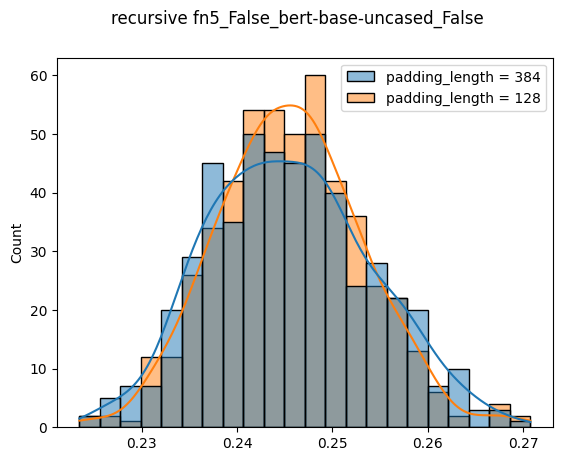

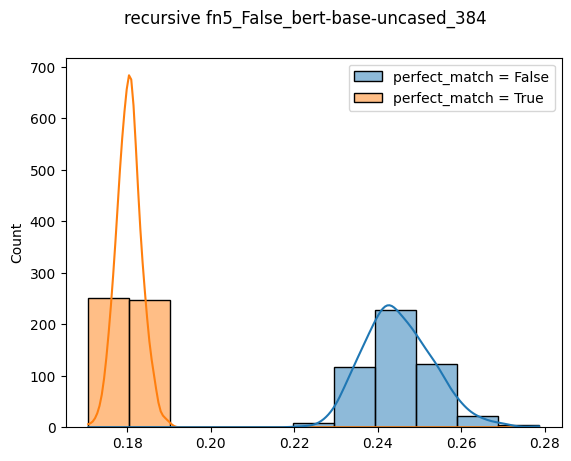

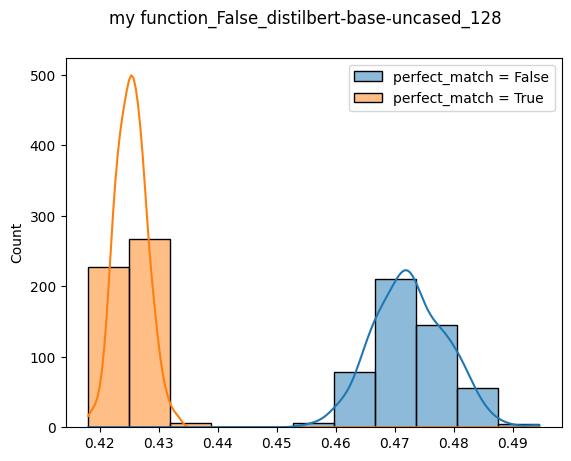

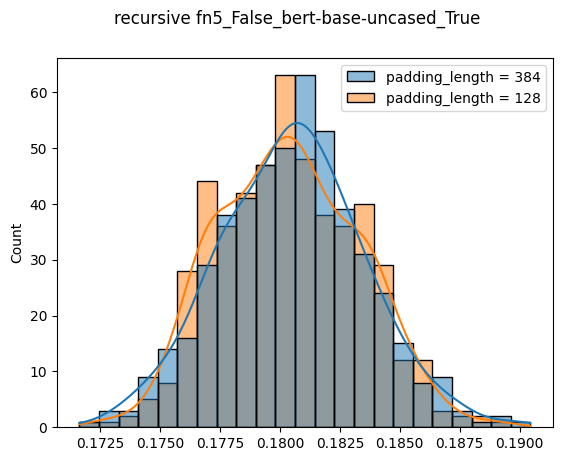

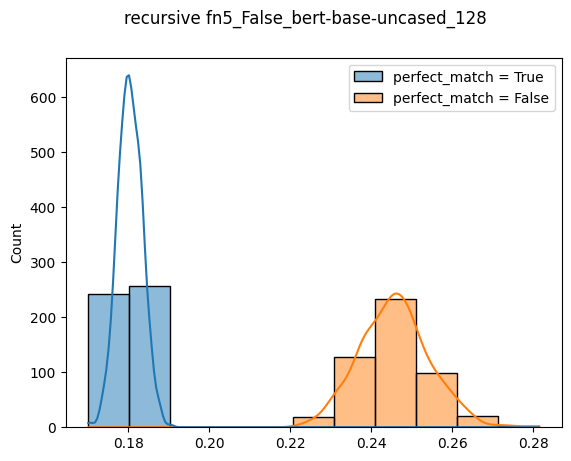

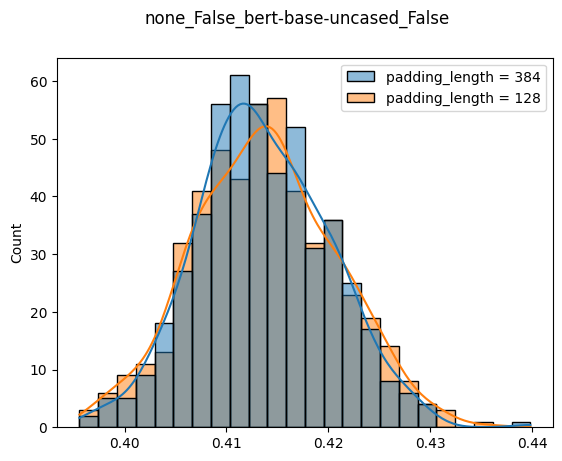

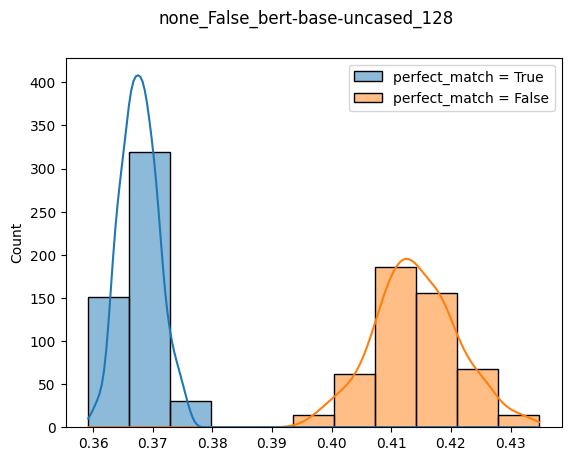

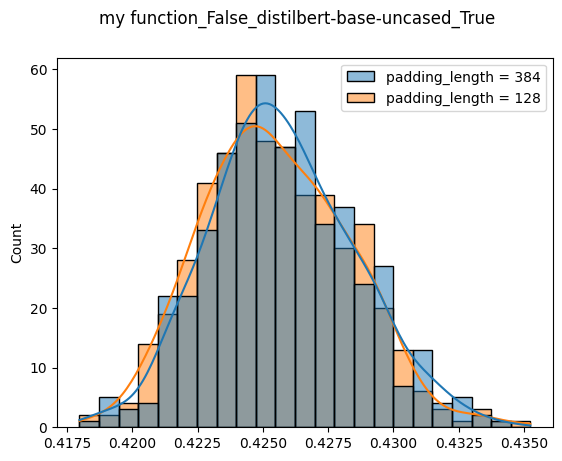

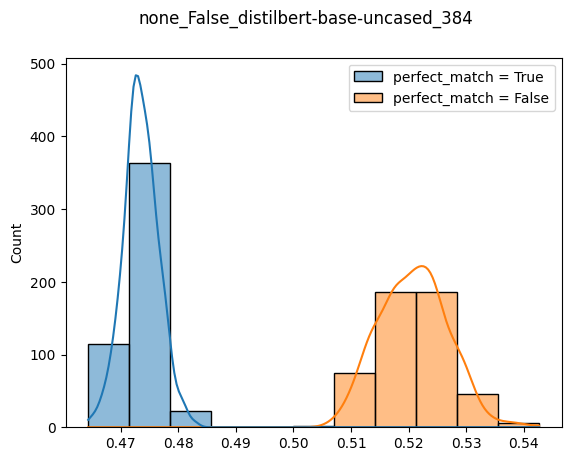

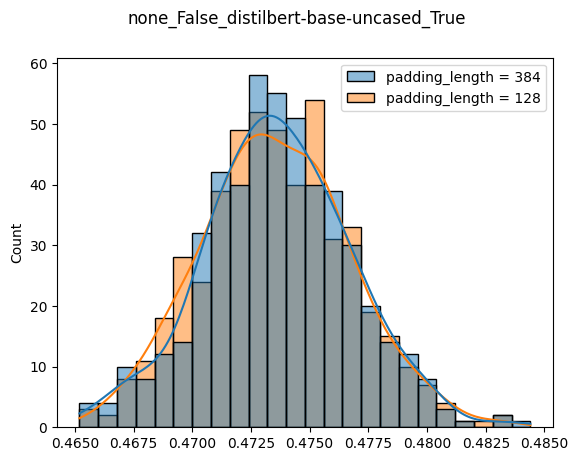

In [12]:
import seaborn as sns
# %matplotlib_inline
import matplotlib.pyplot as plt
from tqdm import tqdm
dir="./graphs"
import os
os.makedirs(dir,exist_ok=True)
for i,key in tqdm(enumerate(tests)):
    if ("bert-base-uncased") in key:
        figure=plt.figure(i)
        plot=sns.histplot(data=tests[key], kde = True,)
        figure.suptitle(key)
        #escape keys
        name=key.replace("/","-")

        #save figure

        plt.savefig(os.path.join(dir,'{}.svg'.format(name)))